# Titanic - Machine Learning from Disaster

In this notebook, our goal is to develop a predictive model to determine whether a passenger would have survived the Titanic shipwreck based on various attributes in the Titanic dataset. This project is inspired by the Kaggle competition of the same name. The detailed overview of the Kaggle competition can be found [here](https://www.kaggle.com/competitions/titanic/overview).

The dataset(s) employed in this project:

- Titanic dataset


In [1]:
# Import libraries here
import json
import os
from typing import Any, Callable, Literal
from zipfile import ZipFile

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from kaggle import KaggleApi
from keras.callbacks import History
from keras.layers import (
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling1D,
    InputLayer,
    LSTM,
)
from keras.models import Sequential
from keras.optimizers.legacy import Adam
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from numpy.typing import ArrayLike
from scipy import sparse
from sklearn.base import (
    BaseEstimator,
    TransformerMixin,
)
from sklearn.compose import make_column_transformer
from sklearn.ensemble import (
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
)
from sklearn.model_selection import (
    cross_val_score,
    learning_curve,
    train_test_split,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    RobustScaler,
    StandardScaler,
)
from sklearn.svm import SVC
from sklearn.tree import (
    DecisionTreeClassifier,
    plot_tree,
)

In [2]:
# Set the seaborn plot style
sns.set_style('ticks')

In [3]:
# Set the type aliases
MatrixLike = np.ndarray | pd.DataFrame | sparse.spmatrix

## Get the Data

This step involves downloading and unzipping the Titanic dataset.


In [4]:
# Initialize the Kaggle API
api = KaggleApi()
api.authenticate()

# Setup the download path
dataset = 'titanic'
dest_dir = '../data'

# Create the directory if it does not exist
os.makedirs(dest_dir, exist_ok=True)

# Download the Titanic dataset
api.competition_download_files(dataset, path=dest_dir)

# Unzip the dataset files
with ZipFile(f'{dest_dir}/{dataset}.zip', 'r') as zip_ref:
    zip_ref.extractall(f'{dest_dir}/{dataset}')

## Load the Data

This step involves reading the datasets from the csv files.


In [5]:
# Set the path to the dataset
train_path = '../data/titanic/train.csv'
test_path = '../data/titanic/test.csv'

# Create the train and test sets
train_ds = pd.read_csv(train_path)
test_ds = pd.read_csv(test_path)

# Get the size of the datasets
len(train_ds), len(test_ds)

(891, 418)

There are 891 training datapoints and 418 testing datapoints.


## Explore the Data

This step entails an in-depth exploratory data analysis of both the training and test sets to identify common patterns and draw inferences for subsequent processing and cleaning. The primary goal of this step is to comprehend the relationships between the independent variables and the dependent variable, as well as the correlations among the independent variables.


### Visualize the Data


In [6]:
# Peek at the train set
train_ds.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


The dependent variable for this dataset is `Survived` where 1 is "Yes" and 0 is "No".


In [7]:
# Get the summary of the dataset
train_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


There are some missing values in `Age`, `Cabin`, and `Embarked` columns.


In [8]:
# Get the statistics for the data attributes
train_ds.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
def plot_survival_by_attr(df: pd.DataFrame, *, attr: str) -> None:
    """
    Plots the passenger survival count for each attribute label.

    This function creates a barplot that shows the proportion of
    passengers who survived and did not survive for each label of
    the specified attribute.

    Args:
        df (DataFrame): The dataset containing the passenger data.
        attr (str): The attribute name for which survival \
                    proportions are to be plotted.
    """
    # Group the dataset by the attribute labels and then
    # the labels of the Survived column (1 = Yes, 0 = No)
    # and calculate their counts and then the sums of
    # those counts
    counts = df.groupby([attr, 'Survived'], observed=True).size().unstack()
    sums = counts.sum(axis=1)

    # Divide the counts of each label for both the 0 and 1
    # survival ratings by the total number of entries for
    # each label in the attribute to calculate their
    # proportions
    props = counts.div(sums, axis=0)

    # Melt the props dataframe from the wide format to the
    # long format for plotting, i.e., it converts the columns
    # for the 0 and 1 ratings into separate entries for id_vars
    # attribute and creates a new column for the proportions
    props = props.reset_index().melt(id_vars=attr,
                                     var_name='Survived',
                                     value_name='Proportion')

    # Calculate the width of the bars based on the number of labels
    width = min(0.2 * len(df[attr].unique()), 0.8)

    # Plot the barplot for the proportions of survival by attribute
    sns.barplot(props, x=attr, y='Proportion',
                hue='Survived', hue_order=[1, 0], width=width)
    plt.title(f'Passenger Survival Rating for each {attr}')
    plt.grid()

    # Show the plot
    plt.show()

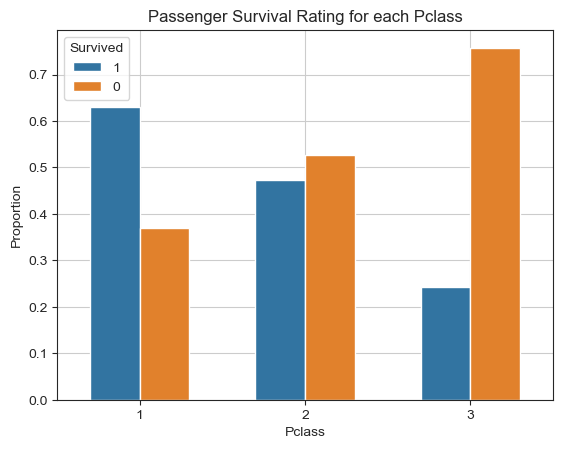

In [10]:
# Plot the survival rating for each passenger class
plot_survival_by_attr(train_ds, attr='Pclass')

The above barplot shows that:

- Passengers in first class were _more_ likely to survive the event.
- Passengers in third class were _less_ likely to survive the event.


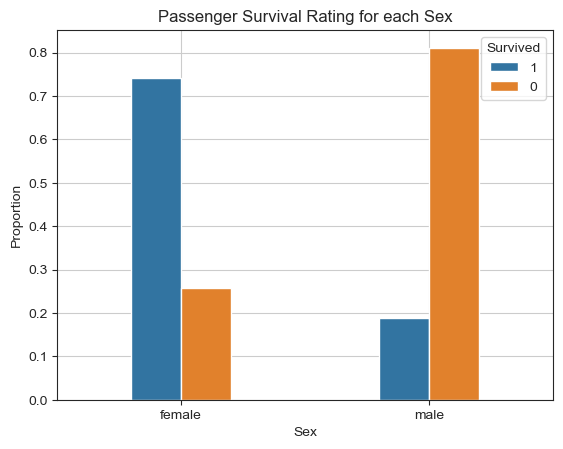

In [11]:
# Plot the survival rating for each sex
plot_survival_by_attr(train_ds, attr='Sex')

The above barplot shows that:

- Female passengers were _more_ likely to survive the event.
- Male passengers were _less_ likely to survive the event.


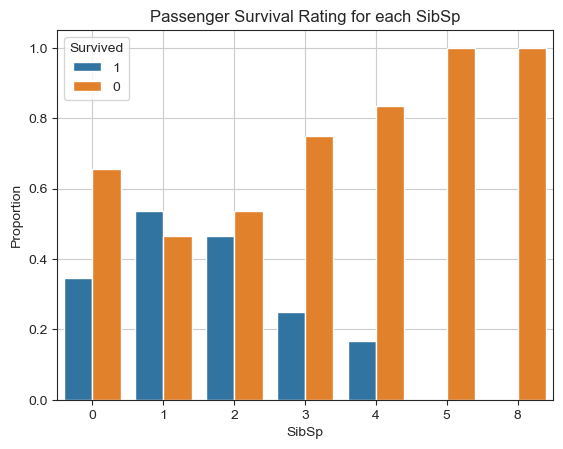

In [12]:
# Plot the survival rating for each passenger based on
# the number of siblings/spouses aboard the Titanic
plot_survival_by_attr(train_ds, attr='SibSp')

The above barplot shows that:

- Passengers with no siblings/spouses were _less_ likely to survive.
- Passengers with 1-2 siblings/spouses were _more_ likely to survive.
- Passengers with 2+ siblings/spouses were _less_ likely to survive.


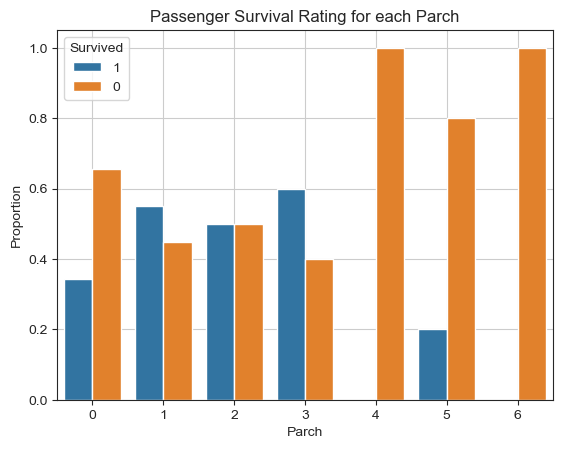

In [13]:
# Plot the survival rating for each passenger based on
# the number of parents/children aboard the Titanic
plot_survival_by_attr(train_ds, attr='Parch')

The above barplot shows that:

- Passengers with no parents/children were _less_ likely to survive.
- Passengers with 1-3 parents/children were _more_ likely to survive.
- Passengers with 3+ parents/children were _less_ likely to survive.


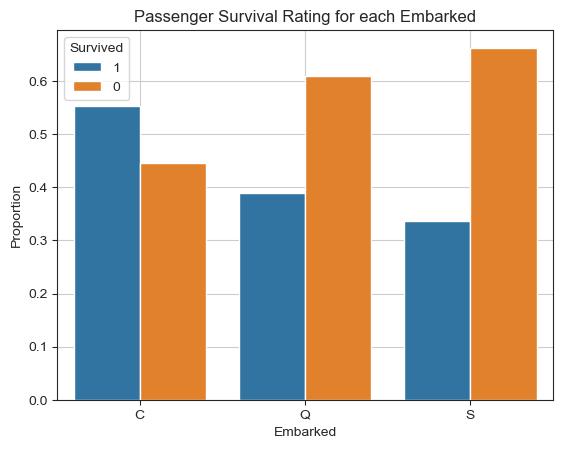

In [14]:
# Plot the survival rating for each passenger based on the port
# of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)
plot_survival_by_attr(train_ds, attr='Embarked')

The above barplot shows that:

- Passengers who embarked from the Cherbourg port were _more_ likely to survive.
- Passengers who embarked from the other ports were _less_ likely to survive.


In [15]:
def plot_attr_dist(
    col: pd.Series,
    *,
    title: str,
    bins: int = 30,
    fontsize: int = 13,
    figsize: list[int] = [13, 5],
) -> None:
    """
    Plots the distribution of the column through a histplot and a boxplot.

    This function generates two plots side-by-side for a given column: a
    histogram with a kernel density estimate (KDE) and a boxplot. This helps
    visualize the distribution, central tendency, spread, and potential
    outliers in the data.

    Args:
        col (Series): The column/attribute to be plotted.
        title (str): The title of the plot.
        bins (int, optional): Number of bins for the histogram. Defaults to 30.
        fontsize (int, optional): Font size for the title. Defaults to 13.
        figsize (list[int], optional): Size of the figure. Defaults to [12, 5].
    """
    # Create a figure with two subplots
    _, axes = plt.subplots(1, 2, figsize=figsize)

    # Plot the histogram on the first subplot
    sns.histplot(col, bins=bins, kde=True, ax=axes[0])

    # Plot the boxplot on the second subplot
    sns.boxplot(col, ax=axes[1])

    # Set the main title and gridlines
    plt.suptitle(title, fontsize=fontsize)
    for ax in axes.flatten():
        ax.grid()

    # Show the figure
    plt.show()

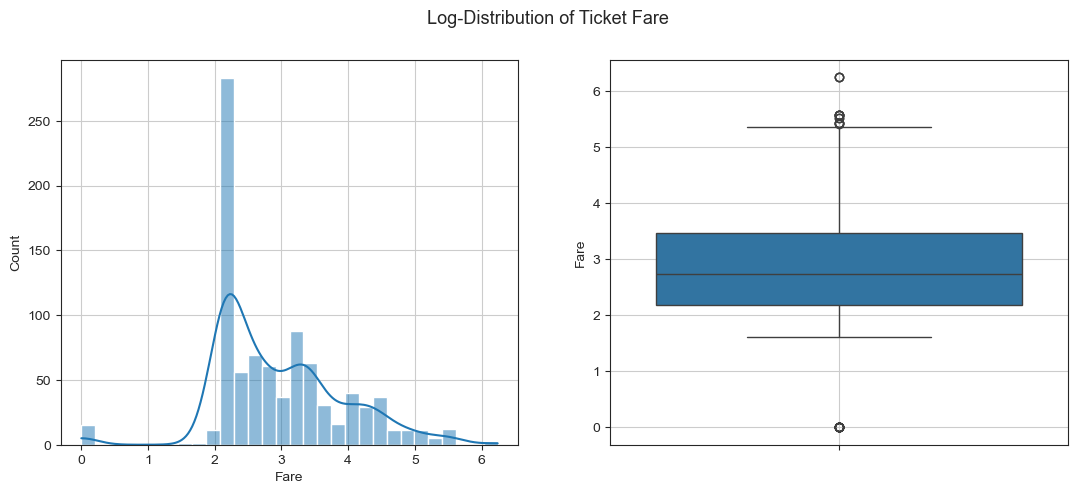

In [16]:
# Plot the log-distribution of the ticket fare among the passengers (due to skewness)
plot_attr_dist(train_ds.Fare.apply(np.log1p), title='Log-Distribution of Ticket Fare')

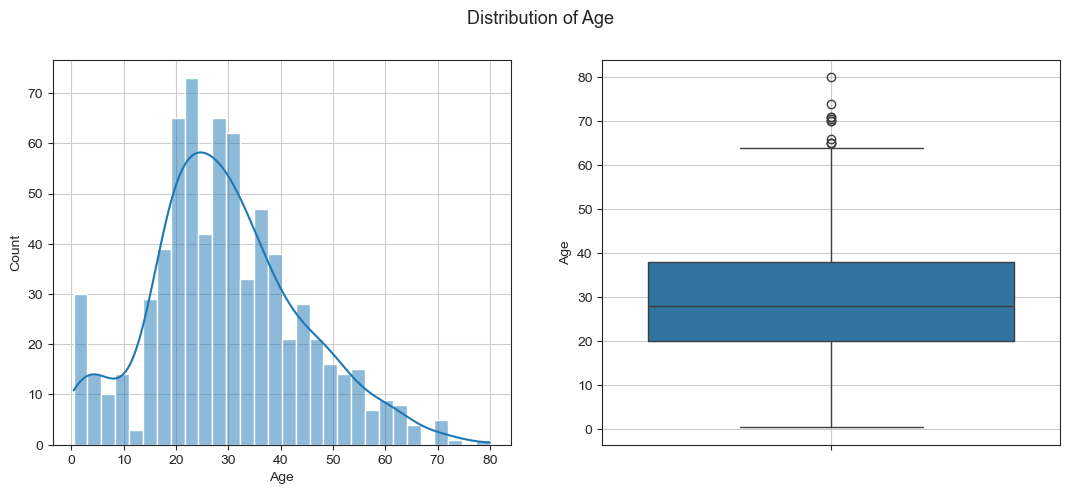

In [17]:
# Plot the distribution of the Age attribute
plot_attr_dist(train_ds.Age.dropna(), title='Distribution of Age')

### Perform Correlation Analysis


In [18]:
# Generate the correlation matrix for the dataset
corr_matrix = train_ds.corr(numeric_only=True)
corr_matrix

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [19]:
# Compare the Pearson's r value for the target variable
corr_matrix['Survived'].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

On one hand, the moderate positive correlation with Fare and negative correlation with Pclass suggest that socio-economic status plays a significant role in measuring the survival ratings of the passengers. On the other hand, family dynamics, Parch and Sibsp, have minor positive and negative effects on survival respectively. Overall, Pclass is the most significant factor among the numerical attributes.


## Preprocess the Data

This step involves applying various preprocessing techniques to prepare the data for the model. These techniques include data cleaning, data reduction, data aggregation, and data transformation. Some important tasks that will be performed for this dataset are:

- Handling missing values
- Attribute aggregation
- Attribute reduction
- Label encode ordinal attributes
- One-hot encode nominal attributes
- Normalize numerical attributes
- Outlier analysis


In [20]:
# Create a copy of the dataset for analysis
train_ds_copy = train_ds.copy(deep=True)

# Select a missing value identifier
UNK: str = 'UNK'

In [21]:
# Peek at the copy of the train set
train_ds_copy.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [22]:
# Get the number of missing entries
train_ds_copy.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Clean the Data

Before handling the missing values, we need to select an important attribute for creating strata.


In [23]:
# Get the possible entries in Pclass since it is a good
# starting attribute for the segregation of the passengers
p_classes = train_ds_copy.Pclass.sort_values().unique()
p_classes

array([1, 2, 3])

In [24]:
# Extract the titles from the Name attribute
train_ds_copy['Title'] = train_ds_copy.Name.str.extract(r'([A-Za-z]+)\.', expand=False)
train_ds_copy['Title'].value_counts()

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: count, dtype: int64

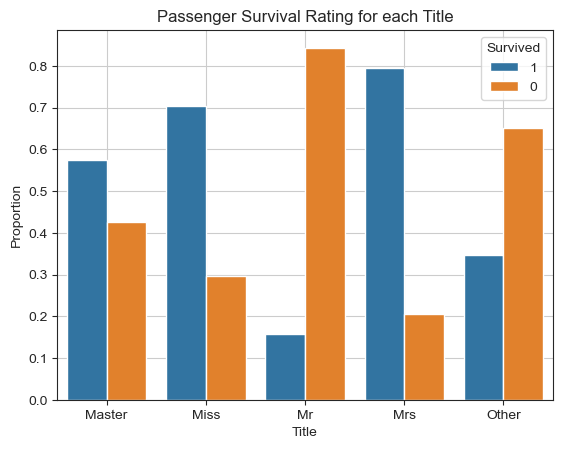

In [25]:
# Setup the title mappings
title_mappings = {
    'Mr': 'Mr',
    'Miss': 'Miss',
    'Mrs': 'Mrs',
    'Master': 'Master',
    'Dr': 'Other',
    'Rev': 'Other',
    'Mlle': 'Miss',
    'Major': 'Other',
    'Col': 'Other',
    'Countess': 'Other',
    'Capt': 'Other',
    'Ms': 'Miss',
    'Sir': 'Other',
    'Lady': 'Other',
    'Mme': 'Mrs',
    'Don': 'Other',
    'Jonkheer': 'Other',
}

# Apply the title mappings to the column
train_ds_copy['Title'] = train_ds_copy.Title.map(title_mappings)

# Plot the survival ratings for each name title
plot_survival_by_attr(train_ds_copy, attr='Title')

The above barplot shows that:

- Passengers with "Mr." titles are _less_ likely to survive.
- Passengers with "Mrs." and "Miss" titles are _more_ likely to survive.


In [26]:
# The closure that fills the NA entries with the median of the group
fill_group_median = lambda x: x.fillna(x.median())

# Fill missing values with the median of the title group
train_ds_copy['Age'] = (
    train_ds_copy.groupby('Title')['Age']
    .transform(fill_group_median)
)
train_ds_copy.Age.describe()

count    891.000000
mean      29.392447
std       13.268389
min        0.420000
25%       21.000000
50%       30.000000
75%       35.000000
max       80.000000
Name: Age, dtype: float64

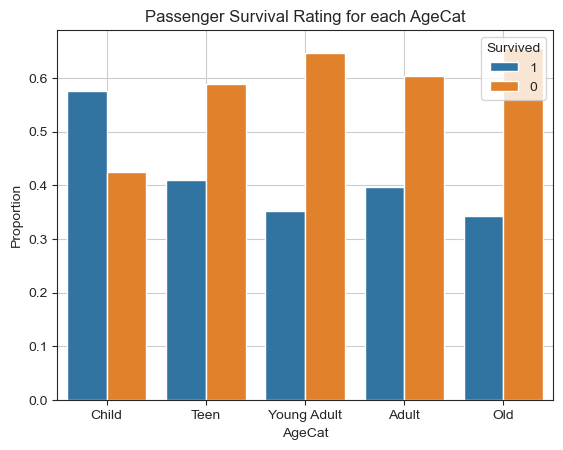

In [27]:
# Create bins for the Age attribute
train_ds_copy['AgeCat'] = pd.cut(
    train_ds_copy['Age'],
    bins=[0., 12., 19., 35., 50., np.inf],
    labels=['Child', 'Teen', 'Young Adult', 'Adult', 'Old'],
    include_lowest=True,
)

# Plot the survival ratings for the age groups
plot_survival_by_attr(train_ds_copy, attr='AgeCat')

In [28]:
# Get the age distribution among the groups
train_ds_copy.AgeCat.value_counts(sort=False)

AgeCat
Child           73
Teen            95
Young Adult    505
Adult          154
Old             64
Name: count, dtype: int64

The above barplot shows that:

- Passengers who were children were _more_ likely to survive.
- Passengers who were aged were _less_ likely to survive.


In [29]:
# Extract ticket prefixes from the Ticket attribute
train_ds_copy['TicketPrefix'] = (
    train_ds_copy.Ticket
        .str.extract(r'([A-Za-z]+)', expand=False)
        .fillna(UNK)
)

# Get the count for each ticket perfix
train_ds_copy.TicketPrefix.value_counts()

TicketPrefix
UNK      661
PC        60
C         33
A         29
STON      18
SOTON     17
S         14
CA        14
SC        13
W         11
F          6
LINE       4
PP         3
P          2
WE         2
SW         1
SCO        1
Fa         1
SO         1
Name: count, dtype: int64

In [30]:
# Assign if the ticket info is missing or not
train_ds_copy['IsTicketMissing'] = train_ds_copy.Ticket.isnull().astype(int)

# Get the cabin missing distribution
train_ds_copy.IsTicketMissing.value_counts()

IsTicketMissing
0    891
Name: count, dtype: int64

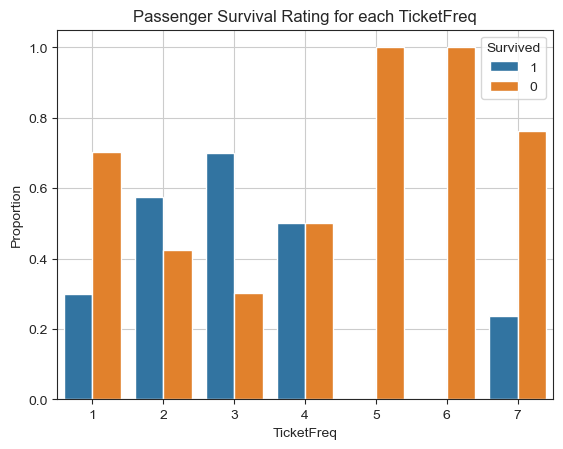

In [31]:
# Get the ticket frequencies in the Ticket attribute
train_ds_copy['TicketFreq'] = (
    train_ds_copy.groupby('Ticket')['Ticket']
        .transform('count')
)

# Plot the survival ratings based on the ticket frequencies
plot_survival_by_attr(train_ds_copy, attr='TicketFreq')

The above barplot shows that:

- Passengers who boarded as an individual are _less_ likely to survive.
- Passengers who boarded as a small group are _more_ likely to survive.
- Passengers who boarded as a large group are _less_ likely to survive.


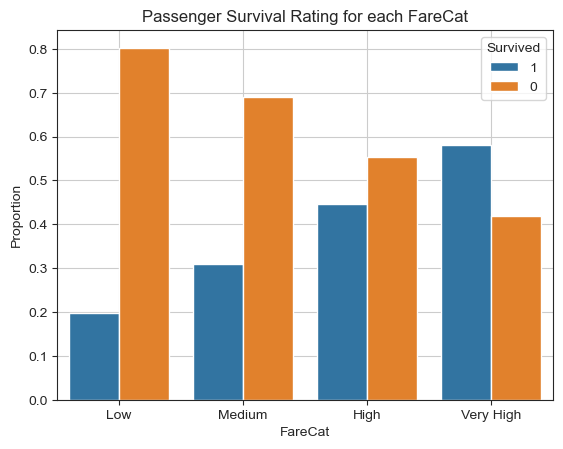

In [32]:
# Create bins for the Fare attribute
train_ds_copy['FareCat'] = pd.cut(
    train_ds_copy['Fare'],
    bins=[0., 7.91, 14.454, 31., np.inf],
    labels=['Low', 'Medium', 'High', 'Very High'],
    include_lowest=True,
)

# Plot the survival ratings for the ticket fare bins
plot_survival_by_attr(train_ds_copy, attr='FareCat')

In [33]:
# Get the ticket fare bin distribution
train_ds_copy.FareCat.value_counts()

FareCat
High         229
Low          223
Very High    222
Medium       217
Name: count, dtype: int64

The above barplot shows that:

- Passengers with low fares were _less_ likely to survive.
- Passengers with high fares were _more_ likely to survive.


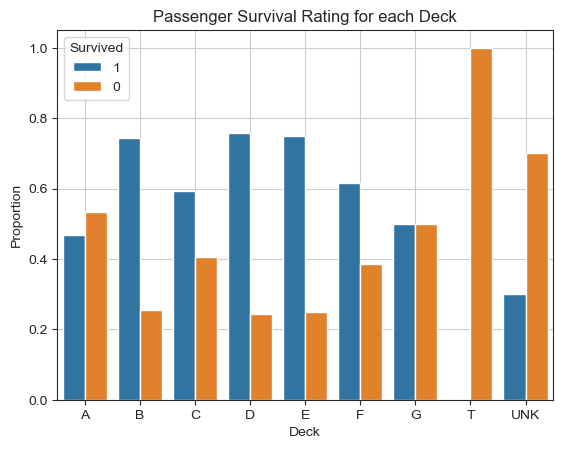

In [34]:
# Extract the deck information from the Cabin attribute
train_ds_copy['Deck'] = (
    train_ds_copy['Cabin'].str.extract(r'([A-Z]+)')
        .fillna(UNK)
)

# Plot the deck information
plot_survival_by_attr(train_ds_copy, attr='Deck')

In [35]:
# Get the deck distribution
train_ds_copy.Deck.value_counts().sort_index()

Deck
A       15
B       47
C       59
D       33
E       32
F       13
G        4
T        1
UNK    687
Name: count, dtype: int64

In [36]:
# Assign if the cabin info is missing or not
train_ds_copy['IsCabinMissing'] = train_ds_copy.Cabin.isnull().astype(int)

# Get the cabin missing distribution
train_ds_copy.IsCabinMissing.value_counts()

IsCabinMissing
1    687
0    204
Name: count, dtype: int64

In [37]:
# Fill the missing values in the Cabin column
train_ds_copy['Cabin'] = train_ds_copy.Cabin.fillna(UNK)

The above barplot shows that:

- Passengers on deck B-F are _more_ likely to survive.


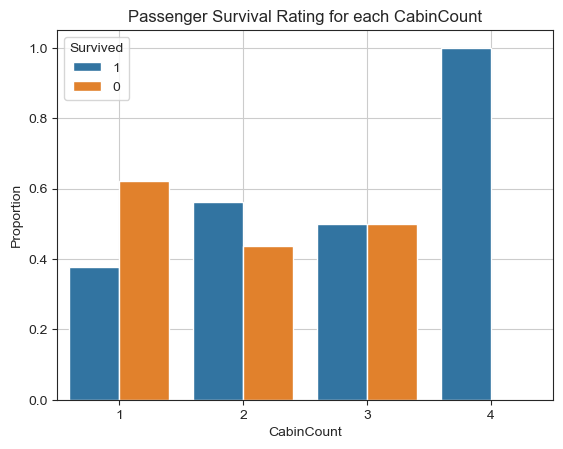

In [38]:
# The closure that returns the number of cabins in each entry
get_cabin_count = lambda x: len(x.split()) if pd.notnull(x) else 0

# Extract the number of cabins assigned to each passenger
train_ds_copy['CabinCount'] = train_ds_copy.Cabin.apply(get_cabin_count)

# Plot the survival ratings for each cabin count
plot_survival_by_attr(train_ds_copy, attr='CabinCount')

In [39]:
# Get the cabin count distribution
train_ds_copy.CabinCount.value_counts()

CabinCount
1    867
2     16
3      6
4      2
Name: count, dtype: int64

The above barplot shows that:

- Passengers with a cabin are _more_ likely to survive.


In [40]:
# Get the value count to facilitate missing value selection
train_ds_copy.Embarked.value_counts(normalize=True)

Embarked
S    0.724409
C    0.188976
Q    0.086614
Name: proportion, dtype: float64

In [41]:
# Get the distribution of the Embarked labels
train_ds_copy.groupby('Embarked').Survived.value_counts(normalize=True, sort=False)

Embarked  Survived
C         0           0.446429
          1           0.553571
Q         0           0.610390
          1           0.389610
S         0           0.663043
          1           0.336957
Name: proportion, dtype: float64

In [42]:
# Calculate the modal value of the Embarked column
modal_value = train_ds_copy.Embarked.mode()[0]

# Fill the missing values in Embarked with the modal value
train_ds_copy['Embarked'] = train_ds_copy['Embarked'].fillna(modal_value)

modal_value

'S'

In [43]:
# Ensure that the missing values are handled
train_ds_copy.isnull().sum().sum() == 0

True

### Handle Outliers


In [44]:
def plot_grouped_boxes(
    df: pd.DataFrame,
    *,
    attr: str,
    p_classes: list[int] = [1, 2, 3]
) -> None:
    """
    Plots the grouped boxplot for a specified attribute, segmented by `Pclass` and `Sex`.

    This function generates a boxplot to visualize the distribution of a specified
    attribute, grouped by both `Pclass` and `Sex`. It helps to compare the distribution
    of the attribute across different passenger classes and sexes.

    Args:
        df (DataFrame): The dataset containing the data.
        attr (str): The attribute for which the distribution is to be plotted.
        p_classes (list[int], optional): The order of `Pclass` to display on \
            the x-axis. Defaults to [1, 2, 3].
    """
    sns.boxplot(df, x='Pclass', y=attr, hue='Sex', order=p_classes)
    plt.title('Distribution of {attr}')
    plt.grid()
    plt.show()

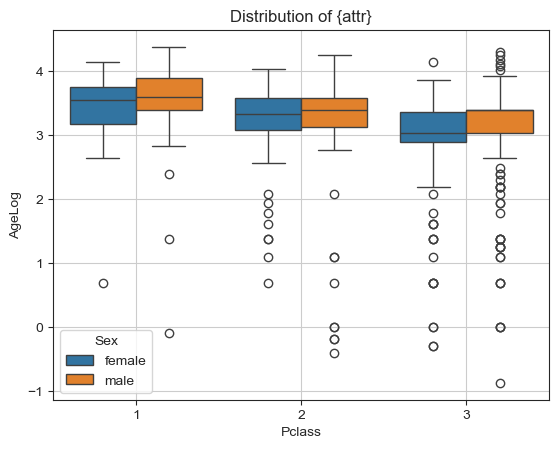

In [45]:
# Log transform (normalise) the Age values
train_ds_copy['AgeLog'] = train_ds_copy.Age.apply(np.log)

# Plot the Age distribution of male and female
# passengers in the three passenger classes
plot_grouped_boxes(train_ds_copy, attr='AgeLog')

According to the figure above, there are multiple outliers in the second and third class subsets.


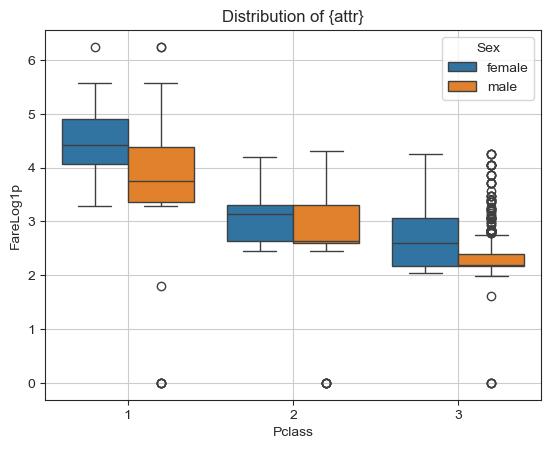

In [46]:
# Log transform the Fare values
train_ds_copy['FareLog1p'] = train_ds_copy.Fare.apply(np.log1p)

# Plot the Fare distribution of male and female
# passengers in the three passenger classes
plot_grouped_boxes(train_ds_copy, attr='FareLog1p')

According to the figure above, there are multiple outliers in the third class subset.


In [47]:
def handle_outliers(group: pd.Series) -> pd.Series:
    """
    Caps the outliers in a Series to a range based on the IQR method.

    This function calculates the interquartile range (IQR) of the provided
    group (a subset of the data) and then caps any values outside the range
    [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR] to the nearest bounds.

    Args:
        group (Series): The grouped subset of the data for which outliers
        need to be handled. This is typically passed as part of a groupby
        operation in pandas.

    Returns:
        Series: The same grouped subset with the outlier values capped to
        the calculated bounds.
    """
    # Compute the first and third quartiles
    Q1 = group.quantile(.25)
    Q3 = group.quantile(.75)

    # Calculate the interquartile range
    IQR = Q3 - Q1

    # Determine the lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f'The bounds of {group.name}: ({lower_bound}, {upper_bound})')
    
    return group.clip(lower_bound, upper_bound)

In [48]:
train_ds_copy.groupby('Pclass')['AgeLog'].apply(handle_outliers);

The bounds of 1: (2.6114380586043486, 4.627058782290017)
The bounds of 2: (2.4634571321387093, 4.25555602224655)
The bounds of 3: (2.387534611391744, 4.009395043824402)


In [49]:
train_ds_copy.groupby('Pclass')['FareLog1p'].apply(handle_outliers);

The bounds of 1: (1.835470178494826, 6.17647762810262)
The bounds of 2: (1.6538880250316523, 4.281006170587935)
The bounds of 3: (1.2175936795640057, 3.7548204017120526)


### Transform the Attributes


In [50]:
# Drop the unnecessary attributes
train_ds_copy.drop(
    columns=[
        'Name',
        'Age',
        'Ticket',
        'Fare',
        'Cabin',
        'AgeCat',
        'FareCat',
    ],
    inplace=True
)

In [51]:
# Split the dataset into features and labels
X = train_ds_copy.drop(columns=['Survived'])
y = train_ds_copy['Survived']

len(X), len(y)

(891, 891)

In [52]:
# Get the features and labels
features = X.columns.values
labels = y.unique()

# Closure to serialize the list items
serialize_list = lambda x: [str(i) for i in list(x)]

print(json.dumps({
    'features': serialize_list(features),
    'labels': serialize_list(labels),
}, indent=2))

{
  "features": [
    "PassengerId",
    "Pclass",
    "Sex",
    "SibSp",
    "Parch",
    "Embarked",
    "Title",
    "TicketPrefix",
    "IsTicketMissing",
    "TicketFreq",
    "Deck",
    "IsCabinMissing",
    "CabinCount",
    "AgeLog",
    "FareLog1p"
  ],
  "labels": [
    "0",
    "1"
  ]
}


In [53]:
# Get the summary of the train features
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PassengerId      891 non-null    int64  
 1   Pclass           891 non-null    int64  
 2   Sex              891 non-null    object 
 3   SibSp            891 non-null    int64  
 4   Parch            891 non-null    int64  
 5   Embarked         891 non-null    object 
 6   Title            891 non-null    object 
 7   TicketPrefix     891 non-null    object 
 8   IsTicketMissing  891 non-null    int64  
 9   TicketFreq       891 non-null    int64  
 10  Deck             891 non-null    object 
 11  IsCabinMissing   891 non-null    int64  
 12  CabinCount       891 non-null    int64  
 13  AgeLog           891 non-null    float64
 14  FareLog1p        891 non-null    float64
dtypes: float64(2), int64(8), object(5)
memory usage: 104.5+ KB


In [54]:
# Select the categorical attributes
cat_attr = ['Sex', 'Embarked', 'Title', 'TicketPrefix', 'Deck']

# Select the numerical attributes
num_attr = ['AgeLog', 'FareLog1p']

In [55]:
# Create a transformation pipeline for the numerical attributes
num_scaler = make_pipeline(
    RobustScaler(),
    StandardScaler(),
)

num_scaler

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('standardscaler', StandardScaler())])

In [56]:
# Create a column transformer to handle the preprocessing
preprocessor = make_column_transformer(
    (OneHotEncoder(), cat_attr),
    (num_scaler, num_attr),
    remainder='passthrough',
)

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder', OneHotEncoder(),
                                 ['Sex', 'Embarked', 'Title', 'TicketPrefix',
                                  'Deck']),
                                ('pipeline',
                                 Pipeline(steps=[('robustscaler',
                                                  RobustScaler()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['AgeLog', 'FareLog1p'])])

In [57]:
# Fit and transform the training set
X_prep = preprocessor.fit_transform(X, y)
X_prep

array([[0., 1., 0., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 0., 1.],
       [1., 0., 0., ..., 1., 1., 1.],
       ...,
       [1., 0., 0., ..., 2., 1., 1.],
       [0., 1., 1., ..., 1., 0., 1.],
       [0., 1., 0., ..., 1., 1., 1.]])

### Standardize the Preprocessing


In [58]:
class GroupImputer(BaseEstimator, TransformerMixin):
    """
    Custom transformer for imputing missing values based on group-specific statistics.

    This transformer imputes missing values in the specified target columns by computing
    group-specific statistics (e.g., median, mean) within the groups defined by `group_by_col`.
    The group-specific statistics are then used to fill in the missing values within each group.
    """
    def __init__(
        self,
        *,
        target_cols: list[str],
        group_by_col: str = 'Pclass',
        strategy: str | Callable = 'median'
    ) -> None:
        super().__init__()
        self.target_cols = target_cols
        self.group_by_col = group_by_col
        self.strategy = strategy

    def fit(self, X: MatrixLike, y: ArrayLike | None = None) -> 'GroupImputer':
        """
        Fits the transformer on `X`.

        Args:
            X (MatrixLike): The input DataFrame to fit on.
            y (ArrayLike | None, optional):\
                The target values (not used in transformers).\
                Defaults to None.

        Returns:
            GroupImputer: Returns the instance itself.
        """
        return self

    def transform(self, X: MatrixLike, y: ArrayLike | None = None) -> MatrixLike:
        """
        Transforms `X` by imputing missing values in the specified target columns.

        Args:
            X (MatrixLike): The input DataFrame to transform.
            y (ArrayLike | None, optional):\
                The target values (not used in transformers).\
                Defaults to None.

        Raises:
            KeyError: If `group_by_col` is not present in `X`.

        Returns:
            MatrixLike: The transformed DataFrame with imputed values.
        """
        X = X.copy(deep=True)

        # Ensure that group_by_col is present
        if self.group_by_col not in X.columns:
            raise KeyError(f"'{self.group_by_col}' column is missing in the DataFrame")

        for col in self.target_cols:
            trans = X.groupby(self.group_by_col)[col].transform(self.strategy)
            X[col] = X[col].fillna(trans)
        
        return X

In [59]:
def preprocess_title(df: pd.DataFrame) -> pd.Series:
    """
    Extracts and preprocesses titles from the `Name` attribute of the input DataFrame.

    Args:
        df (DataFrame): The input DataFrame containing the `Name` column from which\
            titles are to be extracted.

    Returns:
        Series: A Pandas Series containing the preprocessed titles.
    """
    # Extract titles from the Name attribute
    df['Title'] = df['Name'].str.extract(r'([A-Za-z]+)\.', expand=False)

    # Setup the title mappings
    title_mappings = {
        'Mr': 'Mr',
        'Miss': 'Miss',
        'Mrs': 'Mrs',
        'Master': 'Master',
        'Dr': 'Other',
        'Rev': 'Other',
        'Mlle': 'Miss',
        'Major': 'Other',
        'Col': 'Other',
        'Countess': 'Other',
        'Capt': 'Other',
        'Ms': 'Miss',
        'Sir': 'Other',
        'Lady': 'Other',
        'Mme': 'Mrs',
        'Don': 'Other',
        'Jonkheer': 'Other',
    }

    # Apply the title mappings to the column
    df['Title'] = df['Title'].map(title_mappings)

    return df['Title']

In [60]:
def preprocess_ticket_prefix(df: pd.DataFrame) -> pd.Series:
    """
    Extracts the ticket prefixes from the `Ticket` attribute of the input DataFrame.

    Args:
        df (DataFrame): The input DataFrame containing the `Ticket` column from which\
            prefixes are to be extracted.

    Returns:
        Series: A Pandas Series containing the extracted ticket prefixes.
    """
    # Extract ticket prefixes from the Ticket attribute
    df['TicketPrefix'] = df['Ticket'].str.extract(r'([A-Za-z]+)', expand=False)
    
    return df['TicketPrefix']

In [61]:
def preprocess_ticket_freq(df: pd.DataFrame) -> pd.Series:
    """
    Calculates the frequency of each ticket in the `Ticket` attribute of the input DataFrame.

    Args:
        df (DataFrame): The input DataFrame containing the `Ticket` column for which\
            frequencies are to be calculated.

    Returns:
        Series: A Pandas Series containing the frequency of each ticket.
    """
    # Get the ticket frequencies in the Ticket attribute
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    
    return df['TicketFreq']

In [62]:
def preprocess_deck(df: pd.DataFrame) -> pd.Series:
    """
    Extracts deck information from the `Cabin` attribute of the input DataFrame.

    Args:
        df (DataFrame): The input DataFrame containing the `Cabin` column from which\
            deck information is to be extracted.

    Returns:
        Series: A Pandas Series containing the extracted deck information.
    """
    # Extract the deck information from the Cabin attribute
    df['Deck'] = df['Cabin'].str.extract(r'([A-Z]+)')

    return df['Deck']

In [63]:
def preprocess_cabin_count(df: pd.DataFrame) -> pd.Series:
    """
    Calculates the frequency of each cabin in the `Cabin` attribute of the input DataFrame.

    Args:
        df (DataFrame): The input DataFrame containing the `Cabin` column from which\
            the frequencies are to be calculated.

    Returns:
        Series: A Pandas Series containing the calculated frequencies.
    """
    # The closure that returns the number of cabins in each entry
    get_cabin_count = lambda x: len(x.split()) if pd.notna(x) else 0

    # Extract the number of cabins assigned to each passenger
    df['CabinCount'] = df['Cabin'].apply(get_cabin_count)

    return df['CabinCount']

In [64]:
def prepare(df: pd.DataFrame) -> pd.DataFrame:
    """
    Prepares the input DataFrame for further encodings by applying various
    transformations and feature engineering steps.

    Args:
        df (DataFrame):\
            The input DataFrame containing the raw data to be prepared.

    Returns:
        DataFrame: The prepared DataFrame.
    """
    # Create a copy of the original DataFrame
    df_copy = df.copy(deep=True)
    
    # Create an empty DataFrame
    prep_ds = pd.DataFrame()

    # Apply preprocessing techniques to each attribute
    # and add them to the DataFrame
    prep_ds['Pclass'] = df_copy['Pclass']
    prep_ds['Title'] = preprocess_title(df_copy)
    prep_ds['Sex'] = df_copy['Sex']
    prep_ds['AgeLog'] = df_copy['Age'].apply(np.log)
    prep_ds['SibSp'] = df_copy['SibSp']
    prep_ds['Parch'] = df_copy['Parch']
    prep_ds['TicketPrefix'] = preprocess_ticket_prefix(df_copy)
    prep_ds['IsTicketMissing'] = df_copy['Ticket'].isna().astype(int)
    prep_ds['TicketFreq'] = preprocess_ticket_freq(df_copy)
    prep_ds['FareLog1p'] = df_copy['Fare'].apply(np.log1p)
    prep_ds['Deck'] = preprocess_deck(df_copy)
    prep_ds['IsCabinMissing'] = df_copy['Cabin'].isna().astype(int)
    prep_ds['CabinCount'] = preprocess_cabin_count(df_copy)
    prep_ds['Embarked'] = df_copy['Embarked']

    return prep_ds

In [65]:
def preprocess(df: pd.DataFrame) -> np.ndarray | sparse.spmatrix:
    """
    Preprocesses the input DataFrame by performing operations such as handling
    missing values, aggregating features, encoding categorical attributes, and
    scaling numerical attributes.

    This function applies a series of preprocessing steps to the input DataFrame
    to prepare it for machine learning algorithms. The steps include:
        - Handling missing values
        - Creating/Aggregating new features
        - Encoding categorical attributes
        - Scaling numerical attributes

    Args:
        df (DataFrame): The input DataFrame containing the data to be preprocessed.

    Returns:
        ndarray | spmatrix: The preprocessed data.
    """
    # Setup the ordinal, categorical, and numerical attributes
    ord_attr = ['Pclass', 'SibSp', 'Parch']
    cat_attr = ['Title', 'Sex', 'TicketPrefix', 'Deck', 'Embarked']
    num_attr = ['AgeLog', 'FareLog1p']

    # Setup transformers that handles imputation for unknowns
    ord_imputer = (GroupImputer(target_cols=ord_attr), ord_attr)

    # Setup a transformer to encode the categorical attributes
    cat_encoder = (
        make_pipeline(
            OrdinalEncoder(encoded_missing_value=-1),
        ),
        cat_attr,
    )

    # Setup a transformer to scale the numerical attributes
    num_scaler = (
        make_pipeline(
            GroupImputer(target_cols=num_attr),
            RobustScaler(),
            StandardScaler(),
        ),
        num_attr + ['Pclass'],
    )

    # Prepare a column transformer for handling preprocessing
    preprocessor = make_column_transformer(
        ord_imputer,
        cat_encoder,
        num_scaler,
        remainder='passthrough',
    )
    
    # Fit and transform the preprocessed dataset
    return preprocessor.fit_transform(df)

This function is written to ensure that both the training and testing sets are preprocessed the same.


In [66]:
# Separate the features and labels
X = prepare(train_ds.drop(columns=['Survived']))
y = train_ds['Survived']

# Split the train_ds into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      test_size=0.2,
                                                      random_state=42,
                                                      stratify=y)

len(X_train), len(y_train), len(X_valid), len(y_valid)

(712, 712, 179, 179)

In [67]:
# Preprocess the training dataset
X_train = preprocess(X_train)
X_train

array([[3., 0., 0., ..., 7., 1., 0.],
       [2., 0., 0., ..., 1., 1., 0.],
       [1., 0., 0., ..., 1., 0., 1.],
       ...,
       [3., 1., 3., ..., 4., 1., 0.],
       [1., 0., 0., ..., 1., 0., 1.],
       [1., 0., 0., ..., 1., 1., 0.]])

In [68]:
# Preprocess the validation dataset
X_valid = preprocess(X_valid)
X_valid

array([[3., 2., 0., ..., 2., 1., 0.],
       [3., 0., 1., ..., 1., 1., 0.],
       [3., 0., 0., ..., 1., 1., 0.],
       ...,
       [2., 0., 0., ..., 1., 1., 0.],
       [2., 0., 0., ..., 1., 0., 1.],
       [2., 1., 1., ..., 3., 1., 0.]])

In [69]:
# Preprocess the testing dataset
X_test = preprocess(prepare(test_ds))
X_test

array([[3., 0., 0., ..., 1., 1., 0.],
       [3., 1., 0., ..., 1., 1., 0.],
       [2., 0., 0., ..., 1., 1., 0.],
       ...,
       [3., 0., 0., ..., 1., 1., 0.],
       [3., 0., 0., ..., 1., 1., 0.],
       [3., 1., 1., ..., 1., 1., 0.]])

## Select and Train a Model

In this step, an appropriate machine learning model is to be selected and trained using the preprocessed dataset. The goal of this step is to train and compare the performances of different machine learning models to finally select the best performing model. The different machine learning models that will be trained are as follows:

- Model 0: Naive Bayes
- Model 1: Logistic Regression
- Model 2: Decision Tree
- Model 3: Random Forest
- Model 4: Support Vector Classifier
- Model 5: k-Nearest Neighbours
- Model 6: Gradient-Boosted Classifier
- Model 7: Multi-Layer Perceptron
- Model 8: Convolutional Neural Network
- Model 9: Recurrent Neural Network


In [70]:
# Setup containers to store model metadata
models = {}
y_preds = {}
scores = {}

In [71]:
# Setup the target names
target_names = ['Not Survived', 'Survived']

In [72]:
def make_predictions_and_evaluate(name: str) -> None:
    """
    Takes the name of the estimator, makes predictions, and
    prints the predictions and the true values for comparison.

    Compares the predictions to the true values to evaluate the
    performance of the estimator.

    Args:
        name (str): The name of the estimator.
    """
    # Make predictions with the estimator
    y_preds[name] = models[name].predict(X_valid)
    print(f'Predictions : {y_preds[name][:10]}')
    print(f'True Values : {y_valid.to_numpy()[:10]}')

    # Evaluate the predictions
    scores[name] = accuracy_score(
        y_true=y_valid,
        y_pred=y_preds[name],
    )
    print(f'\nAccuracy : {scores[name]*100:.5f}%')

    # Get the classification report for the model predictions
    print('\nClassification Report:')
    print(classification_report(
        y_true=y_valid,
        y_pred=y_preds[name],
        target_names=target_names,
    ))

In [73]:
def plot_learning_curve(
    estimator: Any,
    X: MatrixLike,
    y: MatrixLike | ArrayLike,
    *,
    name: str,
) -> None:
    """
    Plots the learning curve for an estimator by computing training and validation
    scores across varying number of training samples.

    Args:
        estimator (Any):\
            The supervised learning estimator implementing `fit` and `predict`.
        X (MatrixLike): The input feature matrix.
        y (MatrixLike | ArrayLike): The target values.
        name (str): The name of the estimator for labelling the plot.
    """
    # Generate training and validation scores
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator, X, y,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5, scoring='accuracy',
        random_state=42,
    )

    # Compute the mean and standard deviation for the scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(6.4, 4.8))
    plt.fill_between(
        train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1,
    )
    plt.fill_between(
        train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.1,
    )
    plt.plot(train_sizes, train_mean, 'o-', color='b', label='Training score')
    plt.plot(train_sizes, valid_mean, 'o-', color='r', label='Validation score')
    plt.xlabel('Training samples')
    plt.ylabel('Accuracy score')
    plt.title(f'Learning Curve for {name}')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

### Model 0: Naive Bayes


In [74]:
# Fit a Naive Bayes model as a baseline
models['naive_bayes'] = GaussianNB()
models['naive_bayes'].fit(X_train, y_train)

GaussianNB()

In [75]:
# Make predictions and evaluate performance
make_predictions_and_evaluate('naive_bayes')

Predictions : [0 0 0 0 0 0 0 1 1 0]
True Values : [0 0 1 0 1 1 1 0 0 0]

Accuracy : 70.39106%

Classification Report:
              precision    recall  f1-score   support

Not Survived       0.74      0.81      0.77       110
    Survived       0.64      0.54      0.58        69

    accuracy                           0.70       179
   macro avg       0.69      0.67      0.68       179
weighted avg       0.70      0.70      0.70       179



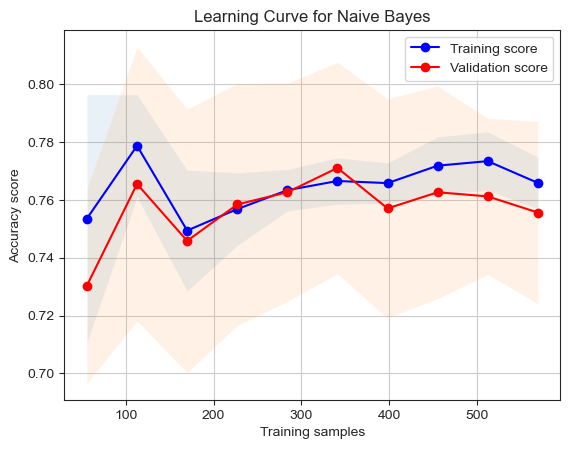

In [76]:
# Plot the learning curve
plot_learning_curve(
    models['naive_bayes'],
    X_train, y_train,
    name='Naive Bayes',
)

### Model 1: Logistic Regression


In [77]:
# Fit a Logistic Regression model
models['log_reg'] = LogisticRegression(
    max_iter=1000,
    solver='liblinear',
    random_state=42,
)
models['log_reg'].fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

In [78]:
# Make predictions and evaluate performance
make_predictions_and_evaluate('log_reg')

Predictions : [0 0 0 0 1 1 1 0 0 0]
True Values : [0 0 1 0 1 1 1 0 0 0]

Accuracy : 81.00559%

Classification Report:
              precision    recall  f1-score   support

Not Survived       0.81      0.91      0.85       110
    Survived       0.82      0.65      0.73        69

    accuracy                           0.81       179
   macro avg       0.81      0.78      0.79       179
weighted avg       0.81      0.81      0.81       179



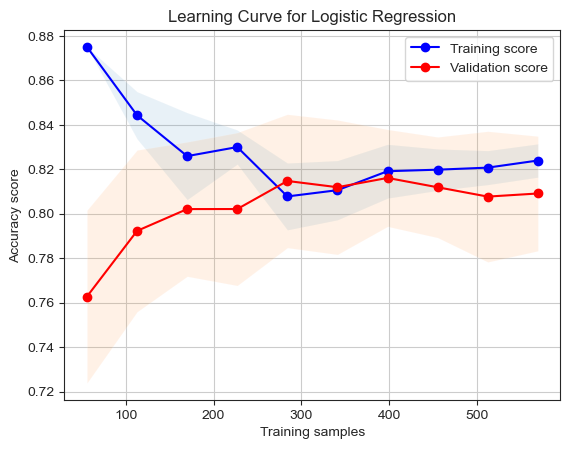

In [79]:
# Plot the learning curve
plot_learning_curve(
    models['log_reg'],
    X_train, y_train,
    name='Logistic Regression',
)

### Model 2: Decision Tree


In [80]:
# Fit a Decision Tree model
models['decision_tree'] = DecisionTreeClassifier(
    max_depth=3,
    max_leaf_nodes=4,
    random_state=42,
)
models['decision_tree'].fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, max_leaf_nodes=4, random_state=42)

In [81]:
# Get the feature importances from the decision tree
models['decision_tree'].feature_importances_

array([0.17923057, 0.        , 0.        , 0.        , 0.71879905,
       0.        , 0.        , 0.        , 0.10197038, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

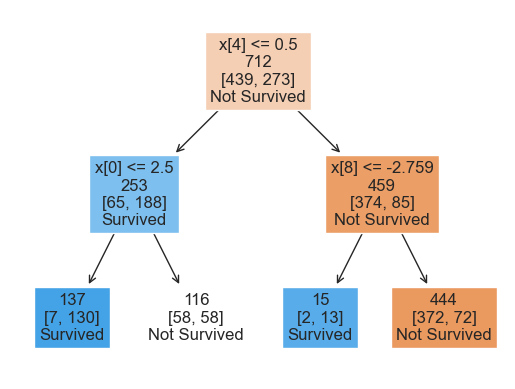

In [82]:
# Plot the decision tree
plot_tree(
    models['decision_tree'],
    filled=True,
    label='none',
    impurity=False,
    class_names=['Not Survived', 'Survived'],
    fontsize=12,
);

In [83]:
# Make predictions and evaluate performance
make_predictions_and_evaluate('decision_tree')

Predictions : [0 0 0 0 0 0 1 0 0 0]
True Values : [0 0 1 0 1 1 1 0 0 0]

Accuracy : 75.97765%

Classification Report:
              precision    recall  f1-score   support

Not Survived       0.73      0.95      0.83       110
    Survived       0.86      0.45      0.59        69

    accuracy                           0.76       179
   macro avg       0.80      0.70      0.71       179
weighted avg       0.78      0.76      0.74       179



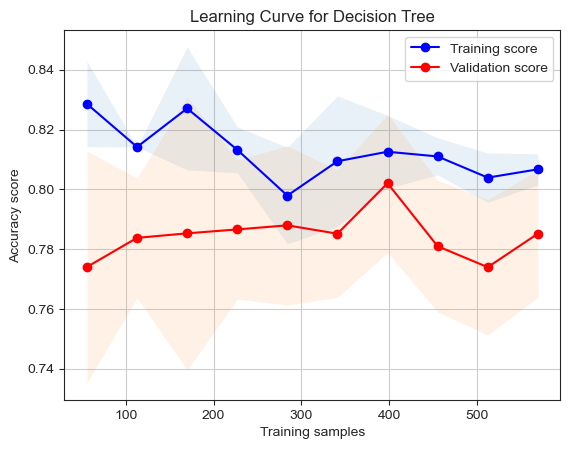

In [84]:
# Plot the learning curve
plot_learning_curve(
    models['decision_tree'],
    X_train, y_train,
    name='Decision Tree',
)

### Model 3: Random Forest


In [85]:
# Fit a Random Forest classifier
models['random_forest'] = RandomForestClassifier(
    n_estimators=50,
    max_depth=3,
    max_leaf_nodes=4,
    random_state=42,
)
models['random_forest'].fit(X_train, y_train)

RandomForestClassifier(max_depth=3, max_leaf_nodes=4, n_estimators=50,
                       random_state=42)

In [86]:
# Peek at the first estimator involved in the ensemble 
models['random_forest'].estimators_[0]

DecisionTreeClassifier(max_depth=3, max_features='sqrt', max_leaf_nodes=4,
                       random_state=1608637542)

In [87]:
# Get the feature importances from the ensemble
models['random_forest'].feature_importances_

array([0.06034352, 0.00395924, 0.00417997, 0.17358992, 0.38660306,
       0.        , 0.07059959, 0.00757682, 0.02238168, 0.07484872,
       0.04064433, 0.        , 0.01857924, 0.05146603, 0.08522787])

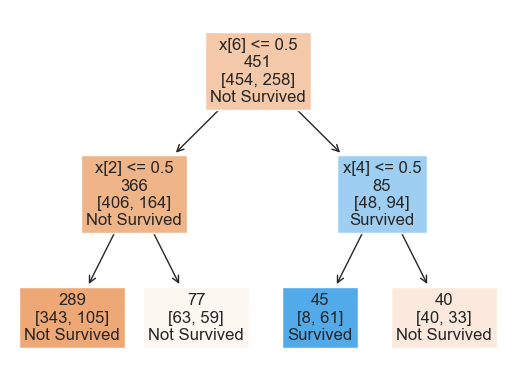

In [88]:
# Plot the first decision tree in the random forest ensemble
plot_tree(
    models['random_forest'].estimators_[0],
    class_names=['Not Survived', 'Survived'],
    label='none',
    filled=True,
    impurity=False,
    fontsize=12,
);

In [89]:
# Make predictions and evaluate performance
make_predictions_and_evaluate('random_forest')

Predictions : [0 0 0 0 1 1 1 1 1 0]
True Values : [0 0 1 0 1 1 1 0 0 0]

Accuracy : 76.53631%

Classification Report:
              precision    recall  f1-score   support

Not Survived       0.81      0.80      0.81       110
    Survived       0.69      0.71      0.70        69

    accuracy                           0.77       179
   macro avg       0.75      0.76      0.75       179
weighted avg       0.77      0.77      0.77       179



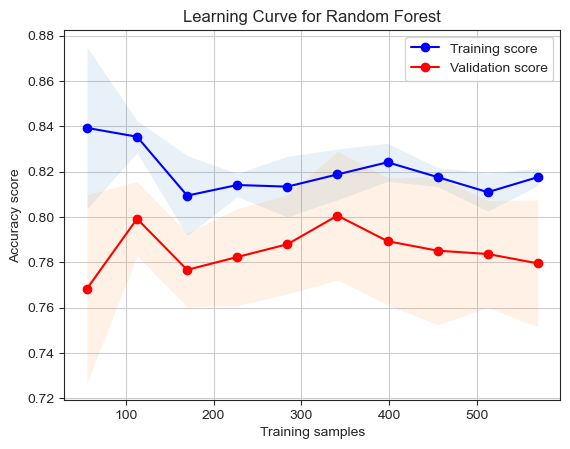

In [90]:
# Plot the learning curve
plot_learning_curve(
    models['random_forest'],
    X_train, y_train,
    name='Random Forest',
)

### Model 4: Support Vector Classifier


In [91]:
# Fit a SVM classifier
models['support_vector'] = SVC(
    C=1.0,
    kernel='rbf',
    degree=3,
    gamma='scale',
    random_state=42,
)
models['support_vector'].fit(X_train, y_train)

SVC(random_state=42)

In [92]:
# Compute the decision function for the first 10 instances
models['support_vector'].decision_function(X_valid)[:10]

array([-1.11097823, -0.97281835, -0.98950651, -1.03274923,  0.79108706,
        0.58672687,  0.88329083, -0.49271663,  0.38293516, -0.99335307])

In [93]:
# Make predictions and evaluate performance
make_predictions_and_evaluate('support_vector')

Predictions : [0 0 0 0 1 1 1 0 1 0]
True Values : [0 0 1 0 1 1 1 0 0 0]

Accuracy : 78.21229%

Classification Report:
              precision    recall  f1-score   support

Not Survived       0.81      0.85      0.83       110
    Survived       0.73      0.68      0.71        69

    accuracy                           0.78       179
   macro avg       0.77      0.76      0.77       179
weighted avg       0.78      0.78      0.78       179



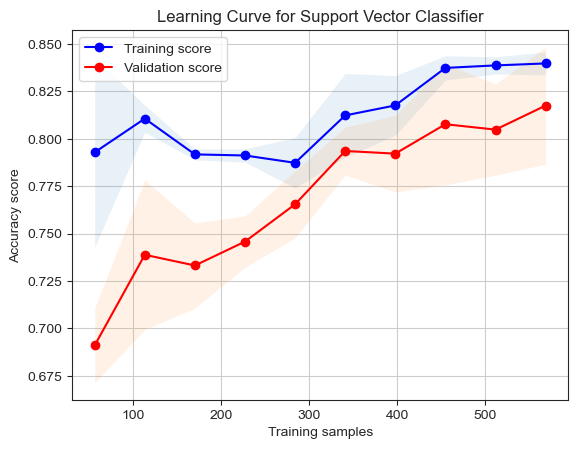

In [94]:
# Plot the learning curve
plot_learning_curve(
    models['support_vector'],
    X_train, y_train,
    name='Support Vector Classifier',
)

### Model 5: k-Nearest Neighbours


In [95]:
def get_optimal_k(X: MatrixLike, y: ArrayLike | MatrixLike) -> int:
    """
    Determines the optimal number of neighbours (k) for the k-Nearest
    Neighbours classifier using cross-validation.

    Args:
        X (MatrixLike):\
            Feature matrix of shape (n_samples, n_features) representing\
            the training data.
        y (ArrayLike | MatrixLike):\
            Target array of shape (n_samples,) representing the class\
            labels for the training data.

    Returns:
        int:\
            The optimal number of neighbours (k) that maximizes the\
            cross-validation accuracy.
    """
    k_values = range(1, 31)
    cv_scores = []
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(
            knn, X, y, cv=5, scoring='accuracy'
        )
        cv_scores.append(scores.mean())

    # Get the optimal k
    optimal_score = max(cv_scores)
    optimal_k = k_values[np.argmax(cv_scores)]

    # Plot cv_scores vs k_values
    data = dict(cv_scores=cv_scores, k_values=k_values)
    plt.plot(k_values, cv_scores, '--')
    plt.plot(optimal_k, optimal_score, 'o', color='black')
    plt.annotate(
        text=f'$k = {optimal_k}$',
        xy=(optimal_k, optimal_score),
        xytext=(optimal_k, optimal_score + 0.01),
        ha='center',
        arrowprops=dict(facecolor='black', shrink=0.1),
    )
    plt.yticks(np.arange(0.75, 0.83, 0.01))
    plt.title('Selecting $k$ for the k-NN Classifier')
    plt.grid()
    plt.show()

    return optimal_k

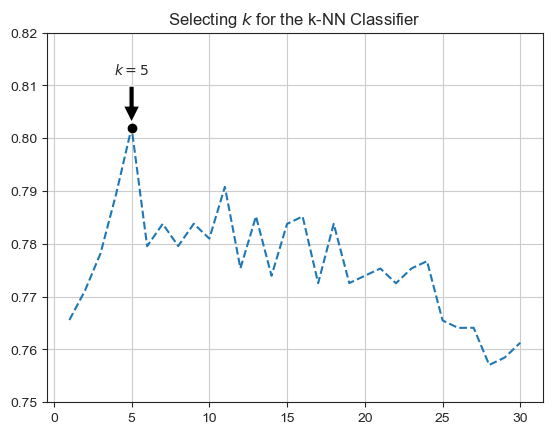

KNeighborsClassifier()

In [96]:
# Fit a k-NN classifier
models['k_nearest_neighbours'] = KNeighborsClassifier(
    n_neighbors=get_optimal_k(X_train, y_train),
)
models['k_nearest_neighbours'].fit(X_train, y_train)

In [97]:
# Make predictions and evaluate performance
make_predictions_and_evaluate('k_nearest_neighbours')

Predictions : [0 0 0 0 1 1 1 1 1 0]
True Values : [0 0 1 0 1 1 1 0 0 0]

Accuracy : 70.39106%

Classification Report:
              precision    recall  f1-score   support

Not Survived       0.75      0.77      0.76       110
    Survived       0.62      0.59      0.61        69

    accuracy                           0.70       179
   macro avg       0.69      0.68      0.68       179
weighted avg       0.70      0.70      0.70       179



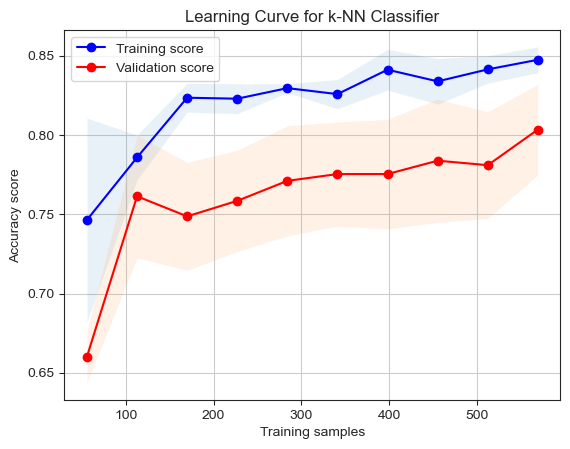

In [98]:
# Plot the learning curve
plot_learning_curve(
    models['k_nearest_neighbours'],
    X_train, y_train,
    name='k-NN Classifier',
)

### Model 6: Gradient-Boosted Classifier


In [99]:
# Fit a Gradient Boosting model
models['gradient_boosting'] = GradientBoostingClassifier(
    learning_rate=0.01,
    n_estimators=50,
    criterion='friedman_mse',
    random_state=42,
    tol=0.0001,
)
models['gradient_boosting'].fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=50, random_state=42)

In [100]:
# Get the feature importances for the gradient-boosted model
models['gradient_boosting'].feature_importances_

array([0.06193752, 0.00727836, 0.        , 0.00157375, 0.61526827,
       0.        , 0.04546882, 0.01787161, 0.0871007 , 0.02763805,
       0.09142386, 0.        , 0.00758447, 0.0200862 , 0.0167684 ])

In [101]:
# Get the first estimator in the ensemble
models['gradient_boosting'].estimators_[0][0]

DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                      random_state=RandomState(MT19937) at 0x31FD5D240)

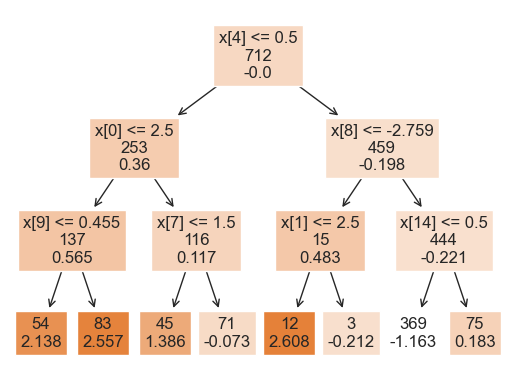

In [102]:
# Plot the decision tree for the first estimator
plot_tree(
    models['gradient_boosting'].estimators_[0][0],
    class_names=['Not Survived', 'Survived'],
    label='none',
    filled=True,
    impurity=False,
    fontsize=12,
);

In [103]:
# Compute the decision function for the first 10 instances
models['gradient_boosting'].decision_function(X_valid)[:10]

array([-0.96224948, -0.96224948, -0.96224948, -0.96224948, -0.128714  ,
       -0.3561386 ,  0.35330512, -0.50751528, -0.3944205 , -0.96224948])

In [104]:
# Make predictions and evaluate performance
make_predictions_and_evaluate('gradient_boosting')

Predictions : [0 0 0 0 0 0 1 0 0 0]
True Values : [0 0 1 0 1 1 1 0 0 0]

Accuracy : 77.65363%

Classification Report:
              precision    recall  f1-score   support

Not Survived       0.74      0.98      0.84       110
    Survived       0.94      0.45      0.61        69

    accuracy                           0.78       179
   macro avg       0.84      0.72      0.73       179
weighted avg       0.82      0.78      0.75       179



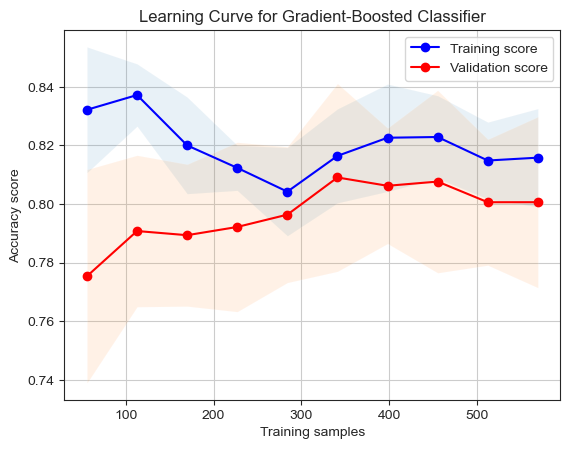

In [105]:
# Plot the learning curve
plot_learning_curve(
    models['gradient_boosting'],
    X_train, y_train,
    name='Gradient-Boosted Classifier',
)

### Model 7: Multi-Layer Perceptron


In [106]:
# Fit a dense MLP classifier
models['mlp_classifier'] = MLPClassifier(
    hidden_layer_sizes=(10,),
    solver='adam',
    activation='relu',
    learning_rate='constant',
    learning_rate_init=0.01,
    max_iter=200,
    early_stopping=True,
    random_state=42,
)
models['mlp_classifier'].fit(X_train, y_train)

MLPClassifier(early_stopping=True, hidden_layer_sizes=(10,),
              learning_rate_init=0.01, random_state=42)

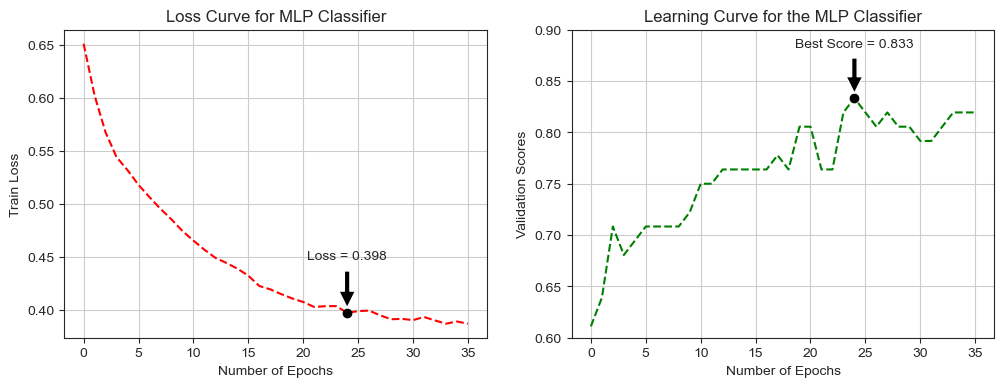

In [107]:
n_epochs = np.arange(models['mlp_classifier'].n_iter_)
train_loss = models['mlp_classifier'].loss_curve_
validation_scores = models['mlp_classifier'].validation_scores_
best_validation_score = models['mlp_classifier'].best_validation_score_
best_epoch = np.argmax(validation_scores)
loss_at_best_epoch = train_loss[best_epoch]

plt.figure(figsize=(12, 4))

# Plot the loss curve
plt.subplot(121)
plt.plot(n_epochs, train_loss, 'r--')
plt.plot(best_epoch, loss_at_best_epoch, 'o', color='black')
plt.annotate(
    text=f'Loss = {loss_at_best_epoch:.3f}',
    xy=(best_epoch, loss_at_best_epoch),
    xytext=(best_epoch, loss_at_best_epoch + 0.05),
    arrowprops=dict(facecolor='black', shrink=0.1),
    ha='center',
)
plt.title('Loss Curve for MLP Classifier')
plt.xlabel('Number of Epochs')
plt.ylabel('Train Loss')
plt.grid()

# Plot the learning curve
plt.subplot(122)
plt.plot(n_epochs, validation_scores, 'g--')
plt.plot(best_epoch, best_validation_score, 'o', color='black')
plt.annotate(
    text=f'Best Score = {best_validation_score:.3f}',
    xy=(best_epoch, best_validation_score),
    xytext=(best_epoch, best_validation_score + 0.05),
    arrowprops=dict(facecolor='black', shrink=0.1),
    ha='center',
)
plt.title('Learning Curve for the MLP Classifier')
plt.xlabel('Number of Epochs')
plt.ylabel('Validation Scores')
plt.yticks(np.arange(0.60, 0.90, 0.05))
plt.grid()

plt.show()

In [108]:
# Make predictions and evaluate performance
make_predictions_and_evaluate('mlp_classifier')

Predictions : [0 0 0 0 1 0 1 0 0 0]
True Values : [0 0 1 0 1 1 1 0 0 0]

Accuracy : 77.09497%

Classification Report:
              precision    recall  f1-score   support

Not Survived       0.77      0.89      0.83       110
    Survived       0.77      0.58      0.66        69

    accuracy                           0.77       179
   macro avg       0.77      0.74      0.74       179
weighted avg       0.77      0.77      0.76       179



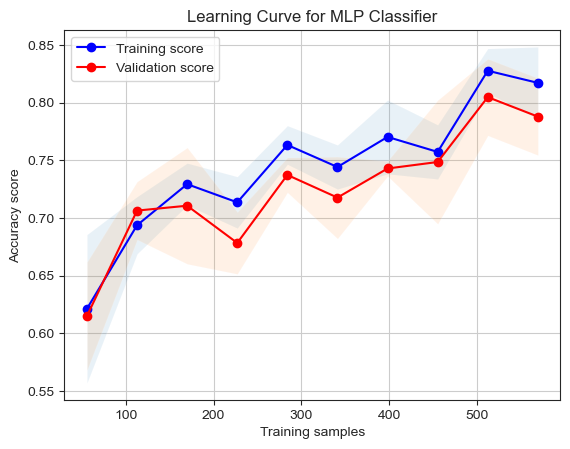

In [109]:
# Plot the learning curve
plot_learning_curve(
    models['mlp_classifier'],
    X_train, y_train,
    name='MLP Classifier',
)

### Model 8: Convolutional Neural Network


In [110]:
# Set the constants
BATCH_SIZE = 32
N_EPOCHS = 25
INPUT_SHAPE = (X_train.shape[1], 1)
AUTOTUNE = tf.data.AUTOTUNE

# Create the datasets
train_data = (
    tf.data.Dataset
        .from_tensor_slices((X_train, y_train))
        .shuffle(buffer_size=len(X_train))
        .batch(BATCH_SIZE)
        .prefetch(buffer_size=AUTOTUNE)
)
valid_data = (
    tf.data.Dataset
        .from_tensor_slices((X_valid, y_valid))
        .shuffle(buffer_size=len(X_valid))
        .batch(BATCH_SIZE)
        .prefetch(buffer_size=AUTOTUNE)
)

len(train_data), len(valid_data)

(23, 6)

In [111]:
def create_cnn_model() -> Sequential:
    """
    Builds and compiles a Convolutional Neural Network (CNN) model.

    Returns:
        keras.Sequential: The compiled CNN model.
    """
    # Set the random seed
    tf.random.set_seed(42)
    
    # Build a CNN model
    model = Sequential([
        InputLayer(
            input_shape=INPUT_SHAPE,
            batch_size=BATCH_SIZE,
            name='input_layer',
        ),
        Conv1D(32, kernel_size=2, activation='relu', name='conv1d_layer'),
        Dropout(0.2, name='dropout_layer'),
        GlobalAveragePooling1D(name='global_average_pooling_layer'),
        Dense(1, activation='sigmoid', name='output_layer'),
    ], name='cnn_model')

    # Compile the model
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.01),
        metrics=['accuracy'],
    )

    return model

In [112]:
# Create the CNN model
models['cnn_model'] = create_cnn_model()

# Get the summary of the model
models['cnn_model'].summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_layer (Conv1D)       (32, 14, 32)              96        
                                                                 
 dropout_layer (Dropout)     (32, 14, 32)              0         
                                                                 
 global_average_pooling_lay  (32, 32)                  0         
 er (GlobalAveragePooling1D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (32, 1)                   33        
                                                                 
Total params: 129 (516.00 Byte)
Trainable params: 129 (516.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [113]:
# Fit the model
cnn_history = models['cnn_model'].fit(
    train_data,
    verbose=0,
    epochs=N_EPOCHS,
    steps_per_epoch=len(train_data),
    validation_data=valid_data,
    validation_steps=len(valid_data),
)
cnn_history

In [114]:
# Visualize the history
pd.DataFrame(cnn_history.history).tail(5)

,loss,accuracy,val_loss,val_accuracy
20,0.626740,0.657303,0.627471,0.625698
21,0.623766,0.662921,0.625838,0.642458
22,0.623892,0.647472,0.657044,0.642458
23,0.629462,0.637640,0.626037,0.653631
24,0.620230,0.654494,0.629071,0.608939


In [115]:
def plot_loss_and_learning_curves(history: History, *, name: str) -> None:
    """
    Plots the loss and learning curves for a Keras model using training
    and validation data.

    Args:
        history (History):\
            History object returned from the Keras model's fit method.
        name (str):\
            The name of the model to be displayed in the plot titles.
    """
    def plot_curve(*, type: Literal['loss', 'accuracy']) -> None:
        """
        Helper function to plot a specific curve (loss or accuracy).

        Args:
            type (Literal['loss', 'accuracy']):\
                The type of curve to plot. Must be either 'loss'\
                or 'accuracy'.
        """
        curve_name = 'Loss' if type == 'loss' else 'Learning'
        sns.lineplot(
            history.history[type],
            marker='o',
            label=f'Training {type}',
        )
        sns.lineplot(
            history.history[f'val_{type}'],
            marker='o',
            label=f'Validation {type}',
        )
        plt.xlabel('Epochs')
        plt.ylabel(type.capitalize())
        plt.title(f'{curve_name} Curve for the {name}')
        plt.grid()

    # Set the figure size
    plt.figure(figsize=(12, 4))
    
    # Plot the loss curve
    plt.subplot(121)
    plot_curve(type='loss')

    # Plot the learning curve
    plt.subplot(122)
    plot_curve(type='accuracy')

    # Show the plot
    plt.show()

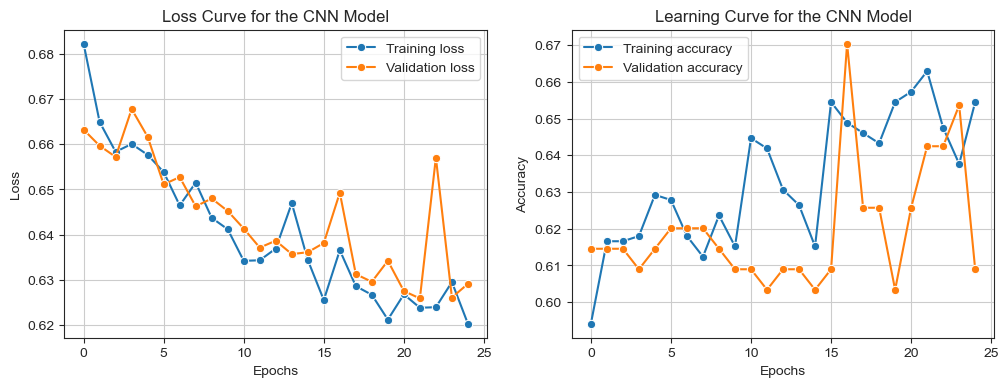

In [116]:
# Plot the loss and learning curves
plot_loss_and_learning_curves(cnn_history, name='CNN Model')

In [117]:
# Make predictions and get the prediction probabilities
y_pred_proba = models['cnn_model'].predict(X_valid)
y_pred_proba[:10]

6/6 [==============================] - 0s 865us/step


array([[0.20953725],
       [0.23639631],
       [0.3145995 ],
       [0.21412444],
       [0.27006996],
       [0.2713546 ],
       [0.34690812],
       [0.3976823 ],
       [0.3636294 ],
       [0.25185424]], dtype=float32)

In [118]:
# Get the predictions
y_preds['cnn_model'] = (
    tf.round(y_pred_proba.T)
        .numpy()
        .astype(int)
        .squeeze()
)
print('Predictions :', y_preds['cnn_model'][:10])
print('True Values :', y_valid.to_numpy()[:10])

# Evaluate the model predictions
scores['cnn_model'] = accuracy_score(
    y_true=y_valid,
    y_pred=y_preds['cnn_model'],
)
print(f"\nAccuracy : {scores['cnn_model']*100:.5f}%")

# Get the classification report for the model predictions
print('\nClassification Report:')
print(classification_report(
    y_true=y_valid,
    y_pred=y_preds['cnn_model'],
    target_names=target_names,
))

Predictions : [0 0 0 0 0 0 0 0 0 0]
True Values : [0 0 1 0 1 1 1 0 0 0]

Accuracy : 60.89385%

Classification Report:
              precision    recall  f1-score   support

Not Survived       0.62      0.96      0.75       110
    Survived       0.43      0.04      0.08        69

    accuracy                           0.61       179
   macro avg       0.52      0.50      0.42       179
weighted avg       0.54      0.61      0.49       179



### Model 9: Recurrent Neural Network


In [119]:
def create_lstm_model() -> Sequential:
    """
    Builds and compiles a LSTM-based Recurrent Neural Network (RNN) model.

    Returns:
        keras.Sequential: The compiled RNN model.
    """
    # Set the random seed
    tf.random.set_seed(42)
    
    # Build a LSTM-based RNN model
    model = Sequential([
        InputLayer(
            input_shape=INPUT_SHAPE,
            batch_size=BATCH_SIZE,
            name='input_layer',
        ),
        LSTM(64, activation='relu', return_sequences=True),
        Dropout(0.2),
        Flatten(),
        Dense(8, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid', name='output_layer'),
    ], name='rnn_model')

    # Compile the model
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.01),
        metrics=['accuracy'],
    )

    return model

In [120]:
# Create the RNN model
models['rnn_model'] = create_lstm_model()

# Get the summary of the model
models['rnn_model'].summary()

Model: "rnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (32, 15, 64)              16896     
                                                                 
 dropout (Dropout)           (32, 15, 64)              0         
                                                                 
 flatten (Flatten)           (32, 960)                 0         
                                                                 
 dense (Dense)               (32, 8)                   7688      
                                                                 
 dropout_1 (Dropout)         (32, 8)                   0         
                                                                 
 output_layer (Dense)        (32, 1)                   9         
                                                                 
Total params: 24593 (96.07 KB)
Trainable params: 24593 (9

In [121]:
# Fit the model
rnn_history = models['rnn_model'].fit(
    train_data,
    verbose=0,
    epochs=N_EPOCHS,
    steps_per_epoch=len(train_data),
    validation_data=valid_data,
    validation_steps=len(valid_data),
)
rnn_history

In [122]:
# Visualize the history
pd.DataFrame(rnn_history.history).tail(5)

,loss,accuracy,val_loss,val_accuracy
20,0.444946,0.814607,0.498278,0.815642
21,0.423134,0.828652,0.502016,0.787709
22,0.434379,0.818820,0.488330,0.804469
23,0.430630,0.827247,0.498394,0.798883
24,0.438687,0.824438,0.509270,0.776536


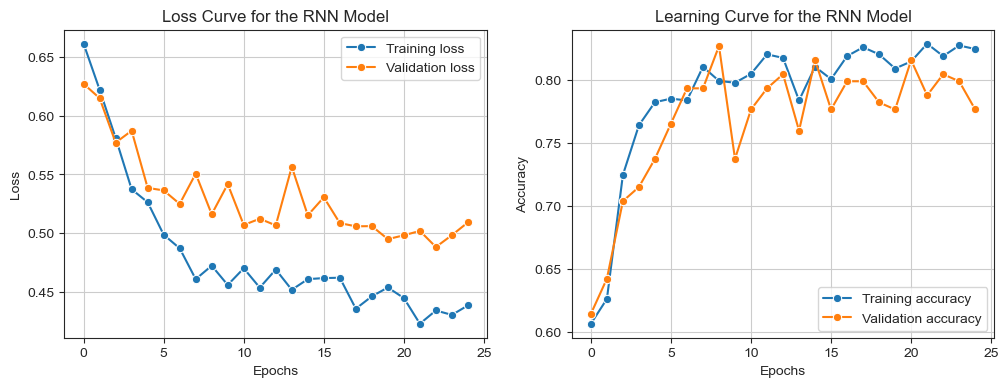

In [123]:
# Plot the loss and learning curves
plot_loss_and_learning_curves(rnn_history, name='RNN Model')

In [124]:
# Make predictions and get the prediction probabilities
y_pred_proba = models['rnn_model'].predict(X_valid)
y_pred_proba[:10]

6/6 [==============================] - 0s 2ms/step


array([[0.18718083],
       [0.05715123],
       [0.19909804],
       [0.05790628],
       [0.68824774],
       [0.7235688 ],
       [0.6774712 ],
       [0.5842514 ],
       [0.7520472 ],
       [0.15533942]], dtype=float32)

In [125]:
# Get the predictions
y_preds['rnn_model'] = (
    tf.round(y_pred_proba.T)
        .numpy()
        .astype(int)
        .squeeze()
)
print('Predictions :', y_preds['rnn_model'][:10])
print('True Values :', y_valid.to_numpy()[:10])

# Evaluate the model predictions
scores['rnn_model'] = accuracy_score(
    y_true=y_valid,
    y_pred=y_preds['rnn_model'],
)
print(f"\nAccuracy : {scores['rnn_model']*100:.5f}%")

# Get the classification report for the model predictions
print('\nClassification Report:')
print(classification_report(
    y_true=y_valid,
    y_pred=y_preds['rnn_model'],
    target_names=target_names,
))

Predictions : [0 0 0 0 1 1 1 1 1 0]
True Values : [0 0 1 0 1 1 1 0 0 0]

Accuracy : 77.65363%

Classification Report:
              precision    recall  f1-score   support

Not Survived       0.87      0.75      0.80       110
    Survived       0.67      0.83      0.74        69

    accuracy                           0.78       179
   macro avg       0.77      0.79      0.77       179
weighted avg       0.79      0.78      0.78       179



## Prepare the Submission


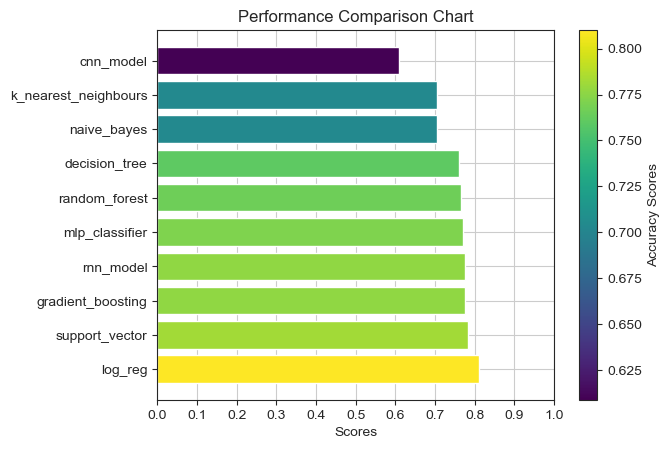

In [126]:
# Compare the performance of all trained models
performance_data = pd.DataFrame({
    'accuracy_scores': scores.values(),
    'models': scores.keys(),
}).sort_values('accuracy_scores', ascending=False).reset_index()

# Set the color mappings
norm = Normalize(vmin=performance_data['accuracy_scores'].min(),
                 vmax=performance_data['accuracy_scores'].max())
sm = ScalarMappable(norm=norm, cmap='viridis')
performance_data['colors'] = (
    performance_data['accuracy_scores']
        .apply(lambda x: sm.to_rgba(x))
)

# Plot the barplot
fig, ax = plt.subplots(figsize=(6.4, 4.8))
ax.barh(
    performance_data['models'],
    performance_data['accuracy_scores'],
    color=performance_data['colors']
)
ax.set_xlabel('Scores')
ax.set_title('Performance Comparison Chart')
ax.set_xticks(np.arange(0.0, 1.1, 0.1))
ax.grid()

# Add a colorbar to the side
cbar = plt.colorbar(mappable=sm, ax=ax)
cbar.set_label('Accuracy Scores')

# Display the plot
plt.show()

In [127]:
# Select the best model
best_model = performance_data['models'][0]
best_model

'log_reg'

In [128]:
# Use the best model to make predictions on the test set
y_pred = np.round(models[best_model].predict(X_test)).astype(int).squeeze()
y_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [129]:
def make_submission(y_pred: ArrayLike, export_dir: str) -> None:
    """
    Generates a submission file with the test set predictions.

    Args:
        y_pred (ArrayLike): The predicted values for the `Survived` column.
        export_dir (str):\
            The directory where the submission CSV file will be exported.
    """
    # Create the directory if it does not exist
    os.makedirs(export_dir, exist_ok=True)

    # Export the submission data to a csv
    export_path = f'{export_dir}submission.csv'    
    pd.DataFrame({
        'PassengerId': test_ds['PassengerId'],
        'Survived': y_pred,
    }).to_csv(export_path, index=False)
    print(f'Submission exported to {export_path}')

In [130]:
# Save the predictions
make_submission(y_pred, export_dir='../data/')

Submission exported to ../data/submission.csv


In [131]:
def save_model(name: str, save_dir: str) -> None:
    """
    Saves the model (from the name) with joblib.

    Args:
        name (str): The name of the model to be saved.
        save_dir (str): The directory where the model is saved.
    """
    # Create the directory if it does not exist
    os.makedirs(save_dir, exist_ok=True)

    # Save the model
    save_path = f'{save_dir}best_model.pkl'
    joblib.dump(models[name], save_path)
    print(f'Model saved at {save_path}')

In [132]:
# Save the best model
save_model(best_model, save_dir='../models/')

Model saved at ../models/best_model.pkl
